In [1]:
from ezc3d import c3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation as R
from scipy.integrate import cumtrapz
from pykalman import KalmanFilter, UnscentedKalmanFilter
%matplotlib inline


## To do to improve the notebook
- create function to extract and clean all three data sources, Milo did this for the accelerometers then copied and pasted

In [2]:
# loading file
c = c3d('../Data/EMA_20210930_02.c3d') #let's use only the first 15 seconds
print(c['parameters']['POINT']['USED']['value'][0]);  # Print the number of points used
point_data = c['data']['points']
points_residuals = c['data']['meta_points']['residuals']
analog_data = c['data']['analogs']

0


In [3]:
# Print the header
print("# ---- HEADER ---- #")
print(f"Number of points = {c['header']['points']['size']}")
print(f"Point frame rate = {c['header']['points']['frame_rate']}")
print(f"Index of the first point frame = {c['header']['points']['first_frame']}")
print(f"Index of the last point frame = {c['header']['points']['last_frame']}")
print("")
print(f"Number of analogs = {c['header']['analogs']['size']}")
print(f"Analog frame rate = {c['header']['analogs']['frame_rate']}")
print(f"Index of the first analog frame = {c['header']['analogs']['first_frame']}")
print(f"Index of the last analog frame = {c['header']['analogs']['last_frame']}")
print("")
print("")
# Print the parameters
print("# ---- PARAMETERS ---- #")
print(f"Number of points = {c['parameters']['POINT']['USED']['value'][0]}")
print(f"Name of the points = {c['parameters']['POINT']['LABELS']['value']}")
print(f"Point frame rate = {c['parameters']['POINT']['RATE']['value'][0]}")
print(f"Number of frames = {c['parameters']['POINT']['FRAMES']['value'][0]}")

print("")
print(f"Number of analogs = {c['parameters']['ANALOG']['USED']['value'][0]}")
print(f"Name of the analogs = {c['parameters']['ANALOG']['LABELS']['value']}")
print(f"Analog frame rate = {c['parameters']['ANALOG']['RATE']['value'][0]}")
print("")
# Print the data
print("# ---- DATA ---- #")
print(f" = {c['data']['points']}")
print(f" = {c['data']['analogs']}")

# ---- HEADER ---- #
Number of points = 0
Point frame rate = 100.0
Index of the first point frame = 0
Index of the last point frame = 14023

Number of analogs = 160
Analog frame rate = 2000.0
Index of the first analog frame = 0
Index of the last analog frame = 280479


# ---- PARAMETERS ---- #
Number of points = 0
Name of the points = []
Point frame rate = 100.0
Number of frames = 14024

Number of analogs = 160
Name of the analogs = ['IM EMG1', 'IM EMG10', 'IM EMG11', 'IM EMG12', 'IM EMG13', 'IM EMG14', 'IM EMG15', 'IM EMG16', 'IM EMG2', 'IM EMG3', 'IM EMG4', 'IM EMG5', 'IM EMG6', 'IM EMG7', 'IM EMG8', 'IM EMG9', 'ACCX1', 'ACCY1', 'ACCZ1', 'GYROX1', 'GYROY1', 'GYROZ1', 'MAGX1', 'MAGY1', 'MAGZ1', 'ACCX10', 'ACCY10', 'ACCZ10', 'GYROX10', 'GYROY10', 'GYROZ10', 'MAGX10', 'MAGY10', 'MAGZ10', 'ACCX11', 'ACCY11', 'ACCZ11', 'GYROX11', 'GYROY11', 'GYROZ11', 'MAGX11', 'MAGY11', 'MAGZ11', 'ACCX12', 'ACCY12', 'ACCZ12', 'GYROX12', 'GYROY12', 'GYROZ12', 'MAGX12', 'MAGY12', 'MAGZ12', 'ACCX13', 'ACCY1

In [4]:
all_labels = c['parameters']['ANALOG']['LABELS']['value']
fs = c['parameters']['ANALOG']['RATE']['value'][0]
all_data = c['data']['analogs']

In [5]:
print('This video is',(c['header']['analogs']['last_frame']+1)/fs, 's long')

This video is 140.24 s long


In [6]:
# cutting first 15 seconds of the video = 1 walk back and forth
all_data = all_data[0,:,:int(fs*15)]

In [7]:
#all_data = all_data[:,::50] # desperate attempt at reducing divergence by downsampling the signal
all_data.shape

(160, 30000)

In [8]:
sens_num = '1' # if you want sensors higher than 10 go below and remove the if len condition

# Extracting accelerometer data

In [9]:
# getting indices of accelerometer data
idx = list()
for i in range(len(all_labels)): 
    if all_labels[i].startswith('ACC'):
        idx.append(i)
        
acc_labels = [x for x in all_labels if x.startswith('ACC')] #selecting acc data labels
acc_labels = [x.replace('ACC','') for x in acc_labels] #dropping ACC letters
acc_data_array = all_data[idx]
acc_data = pd.DataFrame(data = acc_data_array.T, columns = acc_labels)
acc_data.shape

(30000, 48)

In [10]:
print(acc_data.describe())

                 X1            Y1            Z1           X10           Y10  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       2.585658     -6.153110      8.573802      0.784307     -8.188850   
std        3.591146      5.852831      5.941126      4.259846      5.759694   
min      -22.076082    -35.605324    -35.128960    -26.812885    -42.423042   
25%        2.022392     -6.549598      7.872665     -1.276011    -11.075140   
50%        2.576580     -4.344306      8.196842      1.057832     -8.959458   
75%        3.410656     -3.874800      9.449658      3.936567     -4.563853   
max       20.718081     12.759830     42.134045     12.760161      6.344634   

                Z10            X11            Y11            Z11  \
count  30000.000000   30000.000000   30000.000000   30000.000000   
mean       0.339639   33870.631409  -75417.930130   -9744.441536   
std        4.931851   65050.651835   49447.919102   38841.908636   
min      -17.131

In [11]:
labels1 = [x for x in acc_data.columns if x.endswith(sens_num) and len(x)==2 ] #selecting sensor 1, not 11

In [12]:
data_1 = acc_data[labels1]
ACC1 = np.array(data_1) # to array, why not

(0.0, 250.0)

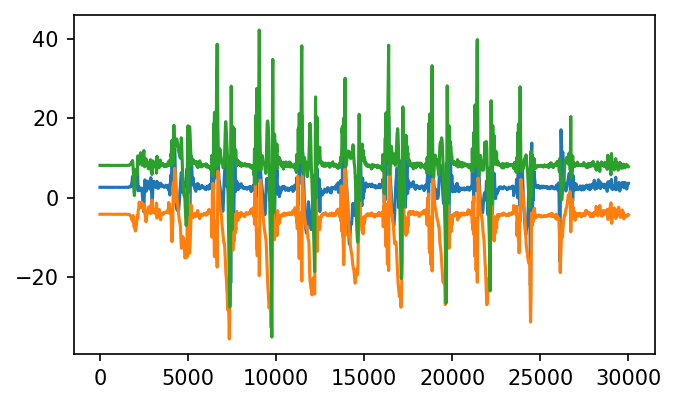

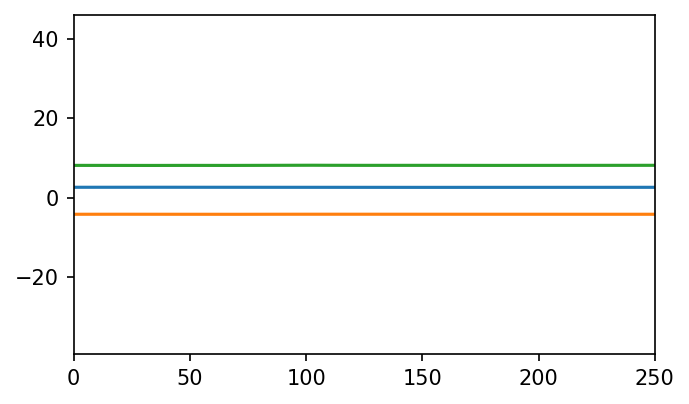

In [13]:
# plotting raw accelerations
plt.figure(dpi = 150, figsize = (5,3) )
plt.plot(ACC1)

# raw data suggests a weird positioning so that gravity is spread in all three directions
plt.figure(dpi = 150, figsize = (5,3) )
plt.plot(ACC1)
plt.xlim([0,250])
#plt.ylim([-10,10])


In [14]:
#intial rotation matrix to get gravity only on the y axis
a = [[0,1,0]]
b = [ACC1[0,:]]/np.linalg.norm(ACC1[0,:])

[init_rotation,temp] = R.align_vectors(a,b)
init_rotation.as_matrix()

/var/folders/v9/xbq6__7j5t96kg172nhbl11w0000gn/T/ipykernel_86202/737951828.py:5: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  [init_rotation,temp] = R.align_vectors(a,b)


array([[-9.62345879e-01, -1.25671593e-01,  2.41033317e-01],
       [ 2.71827904e-01, -4.44912159e-01,  8.53324535e-01],
       [ 1.38777878e-17,  8.86712931e-01,  4.62320428e-01]])

In [15]:
ACC1 = init_rotation.apply(ACC1)

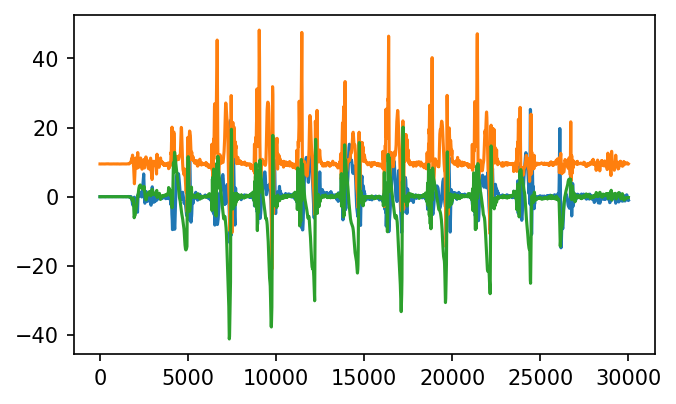

In [16]:
# removed gravity, aligned with a vertical z axis pointing down
plt.figure(dpi = 150, figsize = (5,3) )
plt.plot(ACC1)

# Gyro data

In [17]:
# getting indices of accelerometer data
idx = list()
for i in range(len(all_labels)): 
    if all_labels[i].startswith('GYRO'):
        idx.append(i)
        
gyr_labels = [x for x in all_labels if x.startswith('GYRO')] #selecting gyro data labels
gyr_labels = [x.replace('GYRO','') for x in gyr_labels] #dropping GYRO letters
gyr_data_array = all_data[idx]
gyr_data = pd.DataFrame(data = gyr_data_array.T, columns = gyr_labels)


datagyro_1 = gyr_data[labels1]
GY1 = np.array(datagyro_1) # to array, why not
print(GY1.shape)

(30000, 3)


(-20.0, 20.0)

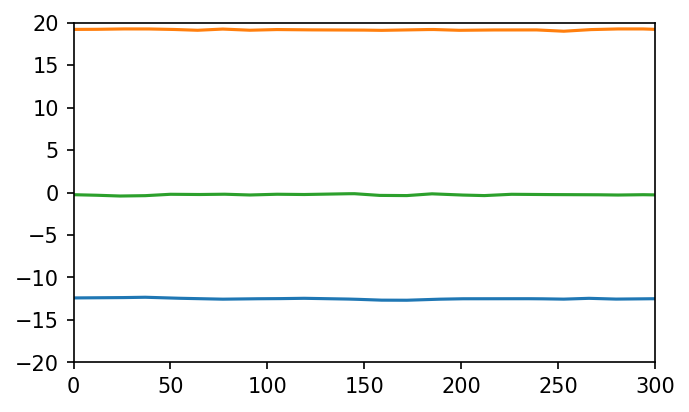

In [18]:
# plotting raw 
plt.figure(dpi = 150, figsize = (5,3) )
plt.plot(GY1)
plt.xlim([0,300])
plt.ylim([-20,20])

In [19]:
# removing initial drift
GY1 = GY1 - GY1[0,:]

In [22]:
kf = KalmanFilter(n_dim_state = 3, n_dim_obs=3)
measurements = GY1[:1000,:] # should be a constant signal
GY1_smooth = kf.em(measurements, n_iter = 10).smooth(GY1)

In [21]:
kf = UnscentedKalmanFilter(n_dim_state = 3, n_dim_obs=3)

GY1_smooth = kf.smooth(GY1)

KeyboardInterrupt: 

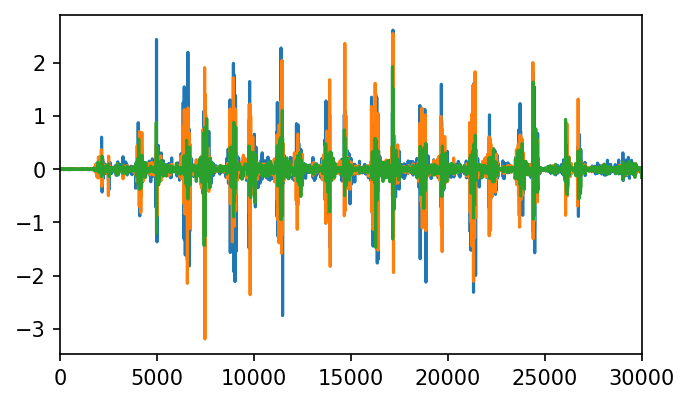

In [24]:
# plotting smooth
(smoothed_GY_state_means, smoothed_state_covariances) = GY1_smooth
plt.figure(dpi = 150, figsize = (5,3) )
plt.plot(smoothed_GY_state_means-GY1)
plt.xlim([0,30000]);

# Magnetometer data, useful for the heading? try to filter it

In [ ]:
# getting indices of accelerometer data
idx = list()
for i in range(len(all_labels)): 
    if all_labels[i].startswith('MAG'):
        idx.append(i)
        
mag_labels = [x for x in all_labels if x.startswith('MAG')] #selecting gyro data labels
mag_labels = [x.replace('MAG','') for x in mag_labels] #dropping GYRO letters
mag_data_array = all_data[idx]
mag_data = pd.DataFrame(data = mag_data_array.T, columns = mag_labels)


datamag_1 = mag_data[labels1]
MG1 = np.array(datamag_1) # to array, why not
print(MG1.shape)

In [ ]:
MG1 = init_rotation.apply(MG1)

In [ ]:
# plotting raw 
plt.figure(dpi = 150, figsize = (5,3) )
plt.plot(MG1)
plt.xlim([0,40000])

# Integration 

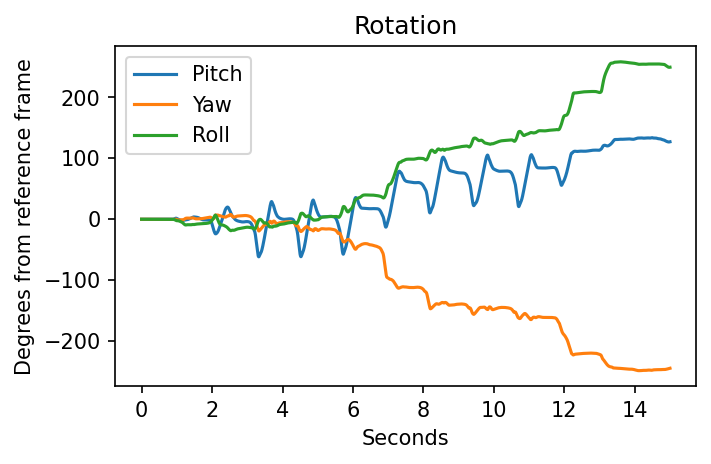

In [31]:
rotation = cumtrapz(smoothed_GY_state_means, axis = 0)/fs

plt.figure(dpi = 150,figsize = (5,3))
plt.plot(np.arange(0,len(rotation))/fs,rotation[:,:])
plt.title('Rotation')
plt.xlabel('Seconds')
plt.ylabel('Degrees from reference frame')
plt.legend(['Pitch','Yaw','Roll'])
plt.show()


In [ ]:
rot_speed = cumtrapz(GY1-np.mean(GY1,axis = 0), axis = 0)
rotation = cumtrapz(rot_speed-np.mean(rot_speed,axis = 0), axis = 0)
plt.plot(rotation[:,:])

In [ ]:
# removing the mean: from Alvarez, 2018
# not really meaningful, but at least the integration doesnt diverge too much...

ACC1 = ACC1 - ACC1[0,:] #removing baseline acceleration to exclude the gravity component, as done above
# this should become a transformation based on the gyro
speed = cumtrapz(ACC1-np.mean(ACC1,axis = 0), axis = 0)/fs # dividing by fs to adjust units

distance = cumtrapz(speed,axis = 0)/fs
plt.plot(distance)

# 3D plotting

In [ ]:
#%matplotlib notebook 

In [ ]:
xdata = distance[:,0]
ydata = distance[:,1]
zdata = distance[:,2]

In [ ]:
plt.figure(dpi = 50)
ax = plt.axes(projection='3d')
ax.plot(xdata, ydata, zdata) # other arguments for scatter3D: c=zdata, cmap='Greens'
#ax.set_xlim([-5e8,5e8])
#ax.set_ylim([0,1e9])
#ax.set_zlim([-5e8,5e8])
ax.auto_scale_xyz
ax.set_box_aspect([1,1,1])
plt.show()
#plt.gca().set_aspect('equal', adjustable='box') doesnt work for 3d plots


haha lol cute